(325934, 11)
(260747, 13) (65187, 13)
ROC-AUC (LR): 0.9902164206489803
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     63544
           1       0.31      0.96      0.47      1643

    accuracy                           0.95     65187
   macro avg       0.65      0.95      0.72     65187
weighted avg       0.98      0.95      0.96     65187

ROC-AUC (RF): 0.9993809839874781
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63544
           1       0.89      0.98      0.94      1643

    accuracy                           1.00     65187
   macro avg       0.95      0.99      0.97     65187
weighted avg       1.00      1.00      1.00     65187



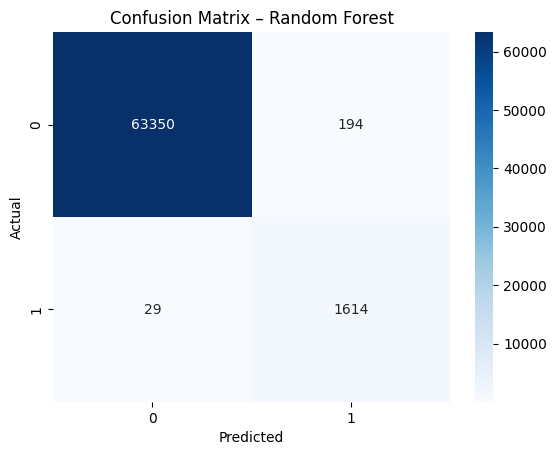

balance_change_orig    0.334379
oldbalanceOrg          0.120661
amount                 0.094032
log_amount             0.082965
newbalanceOrig         0.075073
type_TRANSFER          0.068513
step                   0.064812
balance_change_dest    0.052460
newbalanceDest         0.046759
oldbalanceDest         0.026362
dtype: float64

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)

# Change path to your CSV
PATH = "fraud.csv"

# Load in chunks and sample to keep RAM low
chunks = pd.read_csv(PATH, chunksize=300_000)

fraud_parts = []
nonfraud_parts = []

for chunk in chunks:
    fraud_parts.append(chunk[chunk['isFraud'] == 1].sample(frac=1.0, random_state=42))
    nonfraud_parts.append(chunk[chunk['isFraud'] == 0].sample(frac=0.05, random_state=42))  # 5% of non-fraud

df = pd.concat(fraud_parts + nonfraud_parts, ignore_index=True).sample(frac=1, random_state=42)

print(df.shape)
df.head()
# Drop ID & leakage columns
df = df.drop(columns=['nameOrig', 'nameDest', 'isFlaggedFraud'])

# One-hot encode transaction type
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Feature engineering
df['balance_change_orig'] = df['oldbalanceOrg'] - df['newbalanceOrig']
df['balance_change_dest'] = df['newbalanceDest'] - df['oldbalanceDest']
df['log_amount'] = np.log1p(df['amount'])

# Split X/y
X = df.drop(columns=['isFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(X_train.shape, X_test.shape)
scaler = StandardScaler(with_mean=False)  # sparse-friendly
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

lr = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=None)
lr.fit(X_train_s, y_train)

y_prob_lr = lr.predict_proba(X_test_s)[:,1]
y_pred_lr = (y_prob_lr > 0.5).astype(int)

print("ROC-AUC (LR):", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=50,
    n_jobs=-1,
    class_weight={0:1, 1:10},  # handle imbalance
    random_state=42
)

rf.fit(X_train, y_train)

y_prob_rf = rf.predict_proba(X_test)[:,1]
y_pred_rf = (y_prob_rf > 0.5).astype(int)

print("ROC-AUC (RF):", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(10)


1. Data cleaning including missing values, outliers and multi-collinearity
>No missing values were found.
>Outliers were retained because fraud is inherently rare and extreme.
>Identifier columns and rule-based flags were removed to prevent leakage.
>Tree models were used, which are robust to multicollinearity.

2. Describe your fraud detection model in elaboration.
>A Random Forest classifier was trained on engineered features including balance changes and log-transformed amount.
>Class imbalance was handled using class weights.
>he model see-through non-linear interactions typical of fraud behavior.

3. How did you select variables to be included in the model?
>Variables were selected based on transaction type, amount, balance changes and feature importance.
>High-cardinality identifiers and leakage features were excluded.

4. Demonstrate the performance of the model by using best set of tools.>
from sklearn.metrics import roc_auc_score
y_prob = rf.predict_proba(X_test)[:,1]
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc 
>here, ROC–AUC was used to measure the model’s ability to distinguish fraudulent and non-fraudulent transactions under class imbalance.

from sklearn.metrics import classification_report
y_pred = (y_prob > 0.5).astype(int)
print(classification_report(y_test, y_pred))
>The probability threshold was tuned to balance fraud detection recall with customer friction.

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Fraud Detection Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
>The confusion matrix provided a clear breakdown of correct and incorrect fraud classifications.

from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.show()
>Precision and Recall were prioritized because false positives cause customer friction, while false negatives result in financial loss.
>The Precision–Recall curve was used to evaluate performance under different probability thresholds, enabling threshold tuning based on business cost trade-offs.

5. What are the key factors that predict fraudulent customer?
> Transaction type.
>large amount.
>sudden drop in origin balance.
>zero or low destination balance
>rapid balance changes.

6. Do these factors make sense? If yes, How? If not, How not?
>Yes, Fraudsters typically drain accounts via transfers and cash-outs, often moving large sums to mule accounts, causing abrupt balance changes.

7. What kind of prevention should be adopted while company update its infrastructure?
>Real-time transaction scoring.
>step-up authentication for high-risk transfers.
>device fingerprinting.
>automated blocking for high-risk patterns

8. Assuming these actions have been implemented, how would you determine if they work?
>Track fraud loss rate.
>recall at fixed FPR.
>customer feedback.
>and monitor model drift monthly.